In [50]:
import pandas as pd
from sklearn.feature_selection import mutual_info_regression
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import f_regression
from sklearn.feature_selection import RFE
import numpy as np

In [51]:
train_targets = pd.read_csv('train_targets.csv')
X_test_estimated = pd.read_csv('X_test_estimated.csv')
X_train_estimated = pd.read_csv('X_train_estimated.csv')
X_train_observed = pd.read_csv('X_train_observed.csv')

In [52]:
# Define a function to filter rows where date_forecast is not a whole hour
def filter_whole_hour_rows(df, date_forecast_col='date_forecast'):
    # Parse date_forecast column to datetime
    df[date_forecast_col] = pd.to_datetime(df[date_forecast_col])
    # Filter rows where date_forecast is a whole hour
    df_filtered = df[df[date_forecast_col].dt.minute == 0]
    return df_filtered

# Apply the filter to the datasets
X_test_estimated = filter_whole_hour_rows(X_test_estimated)
X_train_estimated = filter_whole_hour_rows(X_train_estimated)
X_train_observed = filter_whole_hour_rows(X_train_observed)

In [53]:
X_train_observed.isnull().sum()

date_forecast                     0
absolute_humidity_2m:gm3          0
air_density_2m:kgm3               0
ceiling_height_agl:m              0
clear_sky_energy_1h:J             0
clear_sky_rad:W                   0
cloud_base_agl:m                  0
dew_or_rime:idx                   0
dew_point_2m:K                    0
diffuse_rad:W                     0
diffuse_rad_1h:J                  0
direct_rad:W                      0
direct_rad_1h:J                   0
effective_cloud_cover:p           0
elevation:m                       0
fresh_snow_12h:cm                 0
fresh_snow_1h:cm                  0
fresh_snow_24h:cm                 0
fresh_snow_3h:cm                  0
fresh_snow_6h:cm                  0
is_day:idx                        0
is_in_shadow:idx                  0
msl_pressure:hPa                  0
precip_5min:mm                    0
precip_type_5min:idx              0
pressure_100m:hPa                 0
pressure_50m:hPa                  0
prob_rime:p                 

In [54]:
X_train_estimated.isnull().sum()

date_forecast                     0
absolute_humidity_2m:gm3          0
air_density_2m:kgm3               0
ceiling_height_agl:m              0
clear_sky_energy_1h:J             0
clear_sky_rad:W                   0
cloud_base_agl:m                  0
dew_or_rime:idx                   0
dew_point_2m:K                    0
diffuse_rad:W                     0
diffuse_rad_1h:J                  0
direct_rad:W                      0
direct_rad_1h:J                   0
effective_cloud_cover:p           0
elevation:m                       0
fresh_snow_12h:cm                 0
fresh_snow_1h:cm                  0
fresh_snow_24h:cm                 0
fresh_snow_3h:cm                  0
fresh_snow_6h:cm                  0
is_day:idx                        0
is_in_shadow:idx                  0
msl_pressure:hPa                  0
precip_5min:mm                    0
precip_type_5min:idx              0
pressure_100m:hPa                 0
pressure_50m:hPa                  0
prob_rime:p                 

In [55]:
X_test_estimated.isnull().sum()

date_forecast                     0
absolute_humidity_2m:gm3          0
air_density_2m:kgm3               0
ceiling_height_agl:m              0
clear_sky_energy_1h:J             0
clear_sky_rad:W                   0
cloud_base_agl:m                  0
dew_or_rime:idx                   0
dew_point_2m:K                    0
diffuse_rad:W                     0
diffuse_rad_1h:J                  0
direct_rad:W                      0
direct_rad_1h:J                   0
effective_cloud_cover:p           0
elevation:m                       0
fresh_snow_12h:cm                 0
fresh_snow_1h:cm                  0
fresh_snow_24h:cm                 0
fresh_snow_3h:cm                  0
fresh_snow_6h:cm                  0
is_day:idx                        0
is_in_shadow:idx                  0
msl_pressure:hPa                  0
precip_5min:mm                    0
precip_type_5min:idx              0
pressure_100m:hPa                 0
pressure_50m:hPa                  0
prob_rime:p                 

In [56]:
train_targets.isnull().sum()

time              0
pv_measurement    0
dtype: int64

In [57]:
def fill_missing_values(df):
    # Fill missing values in 'snow_density:kgm3' with 0
    df['snow_density:kgm3'].fillna(0, inplace=True)

    # Use forward-fill to fill missing values in 'ceiling_height_agl:m' and 'cloud_base_agl:m'
    df['ceiling_height_agl:m'].fillna(method='ffill', inplace=True)
    df['cloud_base_agl:m'].fillna(method='ffill', inplace=True)

    # Use backward-fill for any remaining missing values in 'ceiling_height_agl:m' and 'cloud_base_agl:m'
    df['ceiling_height_agl:m'].fillna(method='bfill', inplace=True)
    df['cloud_base_agl:m'].fillna(method='bfill', inplace=True)


# Apply the fill_missing_values function to the datasets
fill_missing_values(X_test_estimated)
fill_missing_values(X_train_estimated)
fill_missing_values(X_train_observed)

In [58]:
# Merge the observed features and target variables based on common 'date_forecast' and 'time'
X_train_observed['date_forecast'] = pd.to_datetime(X_train_observed['date_forecast'])
train_targets['time'] = pd.to_datetime(train_targets['time'])

merged_train_data = pd.merge(X_train_observed, train_targets, left_on='date_forecast', right_on='time', how='inner')

In [59]:
# Align your data based on timestamps (if needed)
aligned_data = pd.merge(train_targets, X_train_observed, left_on='time', right_on='date_forecast', how='inner')
y_aligned = aligned_data['pv_measurement']
X_aligned = aligned_data.drop(['time', 'pv_measurement', 'date_forecast'], axis=1)

# Split the data into training and validation sets
# Time-based Splitting (replace 'time' and 'date_forecast' with your actual timestamp columns)
aligned_data = aligned_data.sort_values(by='time')  # Sorting by time

# Split the aligned data into training and validation sets based on time
train_data = aligned_data

# Separate features and target variable for both training and validation sets
X_train = train_data.drop(['time', 'pv_measurement', 'date_forecast'], axis=1)
y_train = train_data['pv_measurement']

# XGBoost Feature Importance
xgb_model = xgb.XGBRegressor(objective ='reg:squarederror', random_seed=42)
xgb_model.fit(X_train, y_train)
xgb_feature_importance = xgb_model.feature_importances_
xgb_feature_importance_df = pd.DataFrame({'Feature': X_train.columns, 'XGB_Importance': xgb_feature_importance})

# Pearson's Correlation (Excluding the timestamp column)
correlation_matrix = aligned_data.drop(['time', 'date_forecast'], axis=1).corr()
correlation_with_target = correlation_matrix['pv_measurement'].sort_values(ascending=False)

# Mutual Information
mutual_info = mutual_info_regression(X_train, y_train)
mutual_info_df = pd.DataFrame({'Feature': X_train.columns, 'Mutual_Info': mutual_info})

# Combine All Feature Importances
combined_feature_importance_df = pd.merge(pd.merge(xgb_feature_importance_df, correlation_with_target, left_on='Feature', right_index=True), mutual_info_df, on='Feature')
combined_feature_importance_df['Total_Importance'] = combined_feature_importance_df['XGB_Importance'] + combined_feature_importance_df['pv_measurement'] + combined_feature_importance_df['Mutual_Info']

# Sort by Total Importance
sorted_combined_feature_importance_df = combined_feature_importance_df.sort_values(by='Total_Importance', ascending=False)

# Display the top 10 most consistently important features
top_10_combined_features = sorted_combined_feature_importance_df.head(20)
print(top_10_combined_features)

C:\Users\marku\anaconda3\lib\site-packages\xgboost\core.py:160: UserWarning: [12:30:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0cec3277c4d9d0165-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "random_seed" } are not used.

  warnings.warn(smsg, UserWarning)


                     Feature  XGB_Importance  pv_measurement  Mutual_Info  \
10              direct_rad:W        0.573550        0.853315     0.741543   
4            clear_sky_rad:W        0.019205        0.803990     0.849480   
36           sun_elevation:d        0.010987        0.691070     0.919494   
8              diffuse_rad:W        0.072609        0.705704     0.821153   
3      clear_sky_energy_1h:J        0.005502        0.781647     0.750533   
11           direct_rad_1h:J        0.005724        0.828454     0.676133   
9           diffuse_rad_1h:J        0.005620        0.689930     0.712687   
19                is_day:idx        0.000242        0.537770     0.574599   
35             sun_azimuth:d        0.044705       -0.064520     0.657787   
38               t_1000hPa:K        0.010155        0.338399     0.086627   
7             dew_point_2m:K        0.014613        0.244038     0.063807   
40              visibility:m        0.007807        0.242822     0.055688   

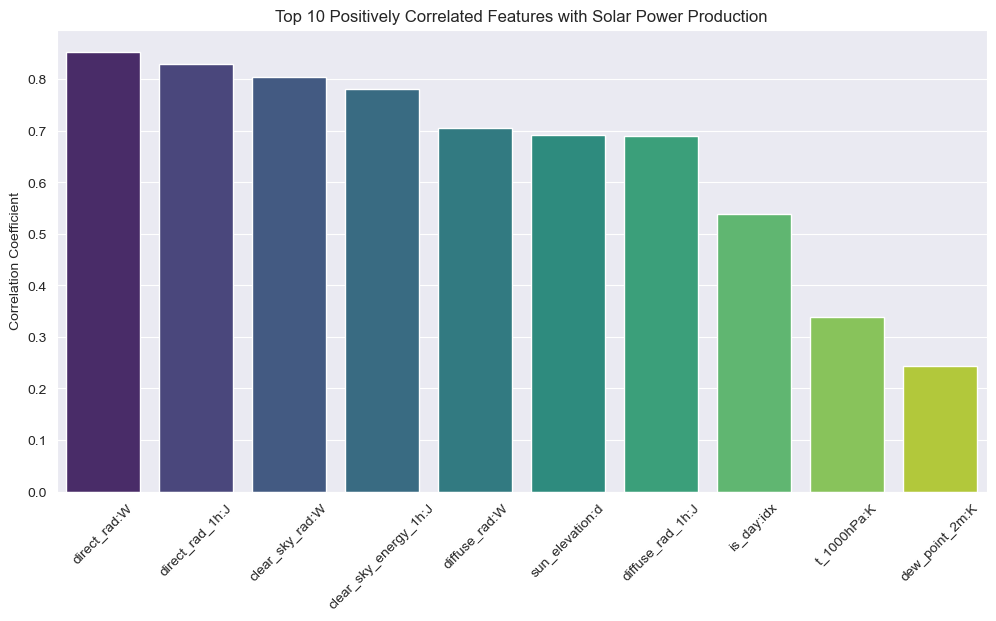

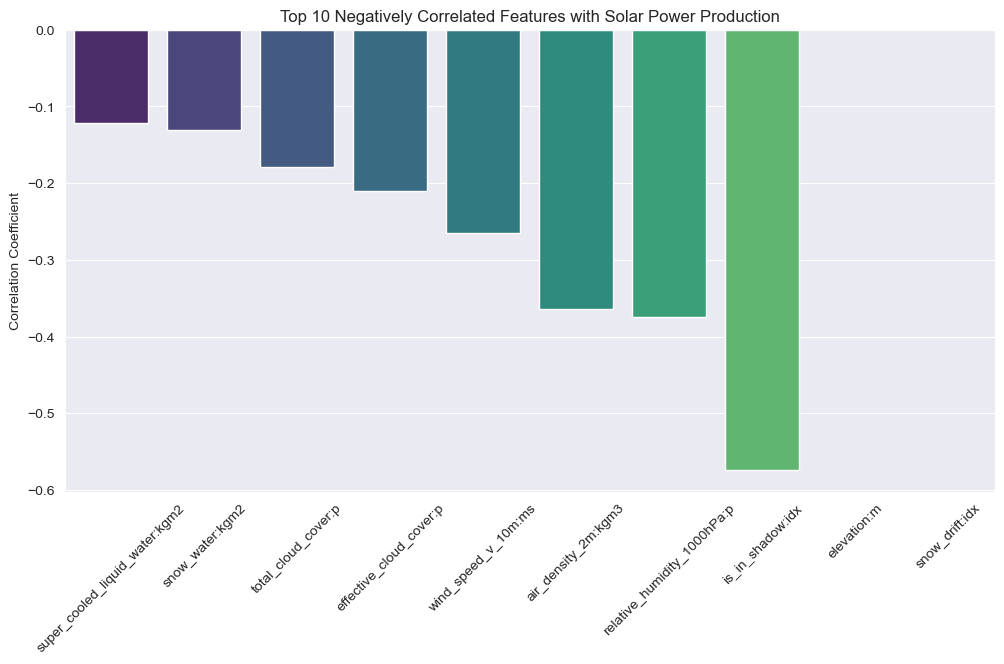

In [60]:
# Drop non-numeric columns from the merged dataset
merged_train_data_numeric = merged_train_data.select_dtypes(include=['number'])

# Calculate the new correlation matrix
correlation_matrix = merged_train_data_numeric.corr()

# Get the correlation of all features with the target variable 'pv_measurement'
target_correlation = correlation_matrix['pv_measurement'].sort_values(ascending=False)

# Display the top 10 positively correlated and top 10 negatively correlated features with the target variable
top_pos_corr = target_correlation.head(11)[1:]  # Exclude the target variable itself
top_neg_corr = target_correlation.tail(10)

# Plot the top positively correlated features
plt.figure(figsize=(12, 6))
sns.barplot(x=top_pos_corr.index, y=top_pos_corr.values, palette='viridis')
plt.title('Top 10 Positively Correlated Features with Solar Power Production')
plt.xticks(rotation=45)
plt.ylabel('Correlation Coefficient')
plt.show()

# Plot the top negatively correlated features
plt.figure(figsize=(12, 6))
sns.barplot(x=top_neg_corr.index, y=top_neg_corr.values, palette='viridis')
plt.title('Top 10 Negatively Correlated Features with Solar Power Production')
plt.xticks(rotation=45)
plt.ylabel('Correlation Coefficient')
plt.show()

In [61]:
# Drop non-feature and non-target columns from the merged data
feature_columns = merged_train_data.drop(columns=['time', 'date_forecast', 'pv_measurement'])

# Perform F-test for feature selection
f_values, p_values = f_regression(feature_columns, merged_train_data['pv_measurement'])

# Create a DataFrame to hold the F-values and p-values
f_test_results = pd.DataFrame({'Feature': feature_columns.columns, 'F_value': f_values, 'p_value': p_values})

# Sort the DataFrame based on F-values in descending order
f_test_results = f_test_results.sort_values(by='F_value', ascending=False)

# Display the results
f_test_results.head(20)

C:\Users\marku\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:289: RuntimeWarning: divide by zero encountered in true_divide
  correlation_coefficient /= X_norms
C:\Users\marku\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:289: RuntimeWarning: invalid value encountered in true_divide
  correlation_coefficient /= X_norms
C:\Users\marku\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:358: RuntimeWarning: invalid value encountered in true_divide
  f_statistic = corr_coef_squared / (1 - corr_coef_squared) * deg_of_freedom


,Feature,F_value,p_value
10,direct_rad:W,79456.002961,0.000000e+00
11,direct_rad_1h:J,64910.615979,0.000000e+00
4,clear_sky_rad:W,54229.170870,0.000000e+00
3,clear_sky_energy_1h:J,46589.309885,0.000000e+00
8,diffuse_rad:W,29430.704347,0.000000e+00
36,sun_elevation:d,27118.538664,0.000000e+00
9,diffuse_rad_1h:J,26947.970090,0.000000e+00
20,is_in_shadow:idx,14549.548491,0.000000e+00
19,is_day:idx,12069.437270,0.000000e+00
28,relative_humidity_1000hPa:p,4837.592935,0.000000e+00


In [62]:
# Initialize XGBoost model with reduced complexity for faster execution
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=1000, random_state=42)

# Drop non-numeric columns from the merged dataset
merged_train_data_numeric = merged_train_data.select_dtypes(include=['number'])

# Separate features and target
X_merged = merged_train_data_numeric.drop(columns=['pv_measurement'])
y_merged = merged_train_data_numeric['pv_measurement']

# Fit the model on the merged dataset
xgb_model.fit(X_merged, y_merged)

# Get feature importances from the model
feature_importances_xgb_merged = xgb_model.feature_importances_

# Create a dictionary to hold feature names and their importance scores
top_features_xgb_merged = {X_merged.columns[i]: feature_importances_xgb_merged[i] for i in range(len(X_merged.columns))}

# Sort the features based on their importance scores and select the top 20
top_features_xgb_merged = {k: v for k, v in sorted(top_features_xgb_merged.items(), key=lambda item: item[1], reverse=True)[:20]}

# Return the top 20 features according to XGBoost on the merged dataset
top_features_xgb_merged

{'direct_rad:W': 0.5733128,
 'diffuse_rad:W': 0.07606112,
 'precip_5min:mm': 0.04818619,
 'sun_azimuth:d': 0.04152699,
 'fresh_snow_24h:cm': 0.026397059,
 'clear_sky_rad:W': 0.018573236,
 'rain_water:kgm2': 0.0151875885,
 'dew_point_2m:K': 0.01255733,
 'wind_speed_u_10m:ms': 0.012167297,
 'pressure_100m:hPa': 0.011719633,
 'super_cooled_liquid_water:kgm2': 0.010417385,
 't_1000hPa:K': 0.009725651,
 'sfc_pressure:hPa': 0.009142516,
 'effective_cloud_cover:p': 0.008731788,
 'wind_speed_10m:ms': 0.0085969465,
 'sun_elevation:d': 0.008399964,
 'snow_water:kgm2': 0.008242629,
 'snow_density:kgm3': 0.008097466,
 'total_cloud_cover:p': 0.007925538,
 'wind_speed_v_10m:ms': 0.0077702184}

In [63]:
# Initialize XGBoost Regressor with reduced complexity for faster execution
xgb_estimator = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=1000, random_state=42)

# Initialize RFE with the XGBoost estimator and number of features to select
xgb_selector = RFE(xgb_estimator, n_features_to_select=20, step=1)

# Fit RFE
xgb_selector = xgb_selector.fit(X_merged, y_merged)

# Get the top features based on RFE with XGBoost
top_features_rfe_xgb = {X_merged.columns[i]: xgb_selector.ranking_[i] for i in range(len(X_merged.columns)) if xgb_selector.support_[i]}

top_features_rfe_xgb

{'clear_sky_rad:W': 1,
 'diffuse_rad:W': 1,
 'direct_rad:W': 1,
 'direct_rad_1h:J': 1,
 'effective_cloud_cover:p': 1,
 'fresh_snow_24h:cm': 1,
 'msl_pressure:hPa': 1,
 'precip_5min:mm': 1,
 'pressure_100m:hPa': 1,
 'rain_water:kgm2': 1,
 'sfc_pressure:hPa': 1,
 'snow_water:kgm2': 1,
 'sun_azimuth:d': 1,
 'sun_elevation:d': 1,
 'super_cooled_liquid_water:kgm2': 1,
 't_1000hPa:K': 1,
 'total_cloud_cover:p': 1,
 'wind_speed_10m:ms': 1,
 'wind_speed_u_10m:ms': 1,
 'wind_speed_v_10m:ms': 1}

In [64]:
mutual_info = mutual_info_regression(X_train, y_train)
mutual_info_df = pd.DataFrame({'Feature': X_train.columns, 'Mutual_Info': mutual_info})
mutual_info_df

,Feature,Mutual_Info
0,absolute_humidity_2m:gm3,0.074087
1,air_density_2m:kgm3,0.109079
2,ceiling_height_agl:m,0.043191
3,clear_sky_energy_1h:J,0.752982
4,clear_sky_rad:W,0.848466
5,cloud_base_agl:m,0.035216
6,dew_or_rime:idx,0.012635
7,dew_point_2m:K,0.062301
8,diffuse_rad:W,0.820184
9,diffuse_rad_1h:J,0.717150


In [65]:
# Generate a list of numeric feature names from the observed or estimated DataFrame
numeric_features = X_train_observed.select_dtypes(include=['number']).columns.tolist()

discrepancy_values = {}
for feature in numeric_features:
    observed_values = X_train_observed[feature]
    estimated_values = X_train_estimated[feature]

    # Calculate mean absolute difference for this feature
    mean_abs_diff = np.mean(np.abs(observed_values - estimated_values))
    discrepancy_values[feature] = mean_abs_diff

# Sort the features by discrepancy
sorted_discrepancy = {k: v for k, v in sorted(discrepancy_values.items(), key=lambda item: item[1], reverse=True)}

sorted_discrepancy

{'clear_sky_energy_1h:J': 767919.5152025489,
 'direct_rad_1h:J': 288649.9578060992,
 'diffuse_rad_1h:J': 194910.57833409193,
 'visibility:m': 21005.564815657715,
 'ceiling_height_agl:m': 2582.656395084206,
 'cloud_base_agl:m': 1533.7193445607647,
 'clear_sky_rad:W': 213.30939918070095,
 'direct_rad:W': 80.29802002730997,
 'diffuse_rad:W': 54.19437869822485,
 'effective_cloud_cover:p': 40.14993172507966,
 'total_cloud_cover:p': 37.42469276285844,
 'snow_density:kgm3': 27.87892580791989,
 'sun_elevation:d': 26.899463814292215,
 'relative_humidity_1000hPa:p': 14.943855257168867,
 'msl_pressure:hPa': 12.610059171597634,
 'sfc_pressure:hPa': 12.57762858443332,
 'pressure_50m:hPa': 12.548338643604914,
 'pressure_100m:hPa': 12.528493400091033,
 'sun_azimuth:d': 10.866352526172053,
 'dew_point_2m:K': 10.531793354574418,
 't_1000hPa:K': 9.673554847519343,
 'absolute_humidity_2m:gm3': 4.075625853436505,
 'wind_speed_u_10m:ms': 3.237687756030952,
 'wind_speed_v_10m:ms': 1.8791761492944925,
 'wind